In [1]:
import numpy as np
import pandas as pd

PATH='data/transactions'
eagg = pd.read_feather(f'{PATH}/entries_agg')
eagg.columns


/home/koendej/apps/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Index(['facility', 'entry_date', 'count'], dtype='object')

In [2]:
len(eagg)

102274

## Missing dates

In [3]:
def resampler(x):
    return x.set_index('entry_date').resample('D').sum()

eaggi = eagg.groupby('facility').apply(resampler)
eaggi.reset_index(inplace=True)
len(eaggi)

110290

In [4]:
col_types = { 'facility': str, 'city': str, 'city_type': str, 'facility_purpose': str, 'facility_type': str }
nl_facilities = pd.read_csv(f"{PATH}/nl_facilities.csv", dtype = col_types)

efc = eaggi.merge(nl_facilities, 'left', ['facility'])

efc[efc['city'].isna()].facility.unique()


array(['0504944', '0505172', '0505339', '0505453', '0510552'],
      dtype=object)

In [5]:
# remove entries with missing city information
# todo: obtain this info
efc.dropna(inplace=True)

In [6]:
len(efc)

113843

In [7]:
efc.drop_duplicates(inplace=True) #whyhwhyhwhyhwhyhw??????

In [8]:
len(efc)

107779

   ## Holidays

In [9]:
efc['entry_date'].min()

Timestamp('2015-01-10 00:00:00')

In [10]:
efc['entry_date'].max()

Timestamp('2018-09-15 00:00:00')

In [11]:
nl_holidays = pd.read_csv(f"{PATH}/nl_holidays.csv", parse_dates=['nl_holiday'])
nl_holidays['nl_holiday'][0]

Timestamp('2015-01-01 00:00:00')

In [12]:
efc['is_holiday'] = 0
for d in nl_holidays.to_records():
    efc.loc[efc['entry_date'] == d[1], 'is_holiday'] = 1


In [13]:
efc.head()

,facility,entry_date,count,city,city_type,facility_purpose,facility_type,is_holiday
0,0500140,2015-12-16,2,Oosterhout,ACities,Multifunction,Combination,0
1,0500140,2015-12-17,0,Oosterhout,ACities,Multifunction,Combination,0
2,0500140,2015-12-18,2,Oosterhout,ACities,Multifunction,Combination,0
3,0500140,2015-12-19,0,Oosterhout,ACities,Multifunction,Combination,0
4,0500140,2015-12-20,1,Oosterhout,ACities,Multifunction,Combination,0


## City and Region

In [14]:
nl_cities = pd.read_csv(f'{PATH}/nl_cities.csv')
efc = efc.merge(nl_cities, 'left', ['city'])
len(efc)

107779

In [15]:
efc.head()

,facility,entry_date,count,city,city_type,facility_purpose,facility_type,is_holiday,region
0,0500140,2015-12-16,2,Oosterhout,ACities,Multifunction,Combination,0,South
1,0500140,2015-12-17,0,Oosterhout,ACities,Multifunction,Combination,0,South
2,0500140,2015-12-18,2,Oosterhout,ACities,Multifunction,Combination,0,South
3,0500140,2015-12-19,0,Oosterhout,ACities,Multifunction,Combination,0,South
4,0500140,2015-12-20,1,Oosterhout,ACities,Multifunction,Combination,0,South


## School holidays

In [16]:
nl_school_holidays = pd.read_csv(f'{PATH}/nl_school_holidays.csv')
nl_school_holidays.head()

,region,begin,end
0,North,2014-12-20,2015-01-04
1,Middle,2014-12-20,2015-01-04
2,South,2014-12-20,2015-01-04
3,South,2015-02-14,2015-02-22
4,Middle,2015-02-21,2015-03-01


In [17]:
efcsh = efc
efcsh['school_holiday'] = 0

for [r, b, e] in nl_school_holidays.values:
    efcsh.loc[(efcsh["region"] == r) & (efcsh["entry_date"] >= b) & (efcsh["entry_date"] <= e), "school_holiday"] = 1

In [18]:
efcsh.head()

,facility,entry_date,count,city,city_type,facility_purpose,facility_type,is_holiday,region,school_holiday
0,0500140,2015-12-16,2,Oosterhout,ACities,Multifunction,Combination,0,South,0
1,0500140,2015-12-17,0,Oosterhout,ACities,Multifunction,Combination,0,South,0
2,0500140,2015-12-18,2,Oosterhout,ACities,Multifunction,Combination,0,South,0
3,0500140,2015-12-19,0,Oosterhout,ACities,Multifunction,Combination,0,South,1
4,0500140,2015-12-20,1,Oosterhout,ACities,Multifunction,Combination,0,South,1


## Extra date info

In [19]:
from fastai.structured import *
from fastai.column_data import *

add_datepart(efcsh, "entry_date", drop=False)

/home/koendej/apps/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
efcsh.head()

,facility,entry_date,count,city,city_type,facility_purpose,facility_type,is_holiday,region,school_holiday,...,entry_Day,entry_Dayofweek,entry_Dayofyear,entry_Is_month_end,entry_Is_month_start,entry_Is_quarter_end,entry_Is_quarter_start,entry_Is_year_end,entry_Is_year_start,entry_Elapsed
0,0500140,2015-12-16,2,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,16,2,350,False,False,False,False,False,False,1450224000
1,0500140,2015-12-17,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,17,3,351,False,False,False,False,False,False,1450310400
2,0500140,2015-12-18,2,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,18,4,352,False,False,False,False,False,False,1450396800
3,0500140,2015-12-19,0,Oosterhout,ACities,Multifunction,Combination,0,South,1,...,19,5,353,False,False,False,False,False,False,1450483200
4,0500140,2015-12-20,1,Oosterhout,ACities,Multifunction,Combination,0,South,1,...,20,6,354,False,False,False,False,False,False,1450569600


In [21]:
import datetime
import calendar

# del max # no idea where this is overridden

def week_of_month(tgtdate):
    tgtdate = pd.to_datetime(tgtdate)
    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we can use the modulo 7 appraoch
    mod = (tgtdate - startdate).days //7 + 1
    return max(mod, 1)

efcsh['wom'] = efcsh['entry_date'].apply(week_of_month)

In [22]:
efcsh.columns

Index(['facility', 'entry_date', 'count', 'city', 'city_type',
       'facility_purpose', 'facility_type', 'is_holiday', 'region',
       'school_holiday', 'entry_Year', 'entry_Month', 'entry_Week',
       'entry_Day', 'entry_Dayofweek', 'entry_Dayofyear', 'entry_Is_month_end',
       'entry_Is_month_start', 'entry_Is_quarter_end',
       'entry_Is_quarter_start', 'entry_Is_year_end', 'entry_Is_year_start',
       'entry_Elapsed', 'wom'],
      dtype='object')

## Durations

In [23]:
def get_elapsed(df, fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.facility.values,df[fld].values, df.entry_date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [24]:
eds = efcsh

print(len(eds))

# is_holiday
fld = 'is_holiday'
# forward
eds = eds.sort_values(['facility', 'entry_date'])
get_elapsed(eds, fld, 'after_')
# backward
eds = eds.sort_values(['facility', 'entry_date'], ascending=[True, False])
get_elapsed(eds, fld, 'before_')


# is_holiday
fld = 'school_holiday'
# forward
eds = eds.sort_values(['facility', 'entry_date'])
get_elapsed(eds, fld, 'after_')
# backward
eds = eds.sort_values(['facility', 'entry_date'], ascending=[True, False])
get_elapsed(eds, fld, 'before_')

print(len(eds))

columns = ['school_holiday', 'is_holiday']
for o in ['before_', 'after_']:
    for p in columns:
        a = o+p
        eds[a] = eds[a].fillna(0).astype(int)


107779
107779


In [25]:
eds.columns


Index(['facility', 'entry_date', 'count', 'city', 'city_type',
       'facility_purpose', 'facility_type', 'is_holiday', 'region',
       'school_holiday', 'entry_Year', 'entry_Month', 'entry_Week',
       'entry_Day', 'entry_Dayofweek', 'entry_Dayofyear', 'entry_Is_month_end',
       'entry_Is_month_start', 'entry_Is_quarter_end',
       'entry_Is_quarter_start', 'entry_Is_year_end', 'entry_Is_year_start',
       'entry_Elapsed', 'wom', 'after_is_holiday', 'before_is_holiday',
       'after_school_holiday', 'before_school_holiday'],
      dtype='object')

In [26]:

eds.set_index('entry_date', inplace=True)

columns = ['school_holiday', 'is_holiday']
bwd = eds[['facility']+columns].sort_index().groupby("facility").rolling(7, min_periods=1).sum()
fwd = eds[['facility']+columns].sort_index(ascending=False).groupby("facility").rolling(7, min_periods=1).sum()

In [27]:
bwd.drop('facility',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('facility',1,inplace=True)
fwd.reset_index(inplace=True)

In [28]:
reds = eds
reds.head()

,facility,count,city,city_type,facility_purpose,facility_type,is_holiday,region,school_holiday,entry_Year,...,entry_Is_quarter_end,entry_Is_quarter_start,entry_Is_year_end,entry_Is_year_start,entry_Elapsed,wom,after_is_holiday,before_is_holiday,after_school_holiday,before_school_holiday
entry_date,,,,,,,,,,,,,,,,,,,,,
2018-08-29,0500140,773,Oosterhout,ACities,Multifunction,Combination,0,South,0,2018,...,False,False,False,False,1535500800,4,100,0,10,0
2018-08-28,0500140,2,Oosterhout,ACities,Multifunction,Combination,0,South,0,2018,...,False,False,False,False,1535414400,4,99,0,9,0
2018-08-27,0500140,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,2018,...,False,False,False,False,1535328000,4,98,0,8,0
2018-08-26,0500140,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,2018,...,False,False,False,False,1535241600,3,97,0,7,0
2018-08-25,0500140,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,2018,...,False,False,False,False,1535155200,3,96,0,6,0


In [29]:
reds = reds.merge(bwd, how='left', on=['entry_date', 'facility'], suffixes=['', '_bw'])
reds = reds.merge(fwd, how='left', on=['entry_date', 'facility'], suffixes=['', '_fw'])

In [30]:
reds.head()

,entry_date,facility,count,city,city_type,facility_purpose,facility_type,is_holiday,region,school_holiday,...,entry_Elapsed,wom,after_is_holiday,before_is_holiday,after_school_holiday,before_school_holiday,school_holiday_bw,is_holiday_bw,school_holiday_fw,is_holiday_fw
0,2018-08-29,0500140,773,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,1535500800,4,100,0,10,0,0.0,0.0,0.0,0.0
1,2018-08-28,0500140,2,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,1535414400,4,99,0,9,0,0.0,0.0,0.0,0.0
2,2018-08-27,0500140,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,1535328000,4,98,0,8,0,0.0,0.0,0.0,0.0
3,2018-08-26,0500140,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,1535241600,3,97,0,7,0,0.0,0.0,0.0,0.0
4,2018-08-25,0500140,0,Oosterhout,ACities,Multifunction,Combination,0,South,0,...,1535155200,3,96,0,6,0,1.0,0.0,0.0,0.0


In [31]:
len(reds)

107779

## Weather

In [32]:
# De Bilt: Middle
# Vlissingen: South
# Eelde: North

# SOURCE: ROYAL NETHERLANDS METEOROLOGICAL INSTITUTE (KNMI)
# Comment: these time series are possibly inhomogeneous because of station relocations and changes in observation techniques. As a result, these series are not suitable for trend analysis. For climate change studies we refer to the homogenized series of stations De Kooy, Eelde, De Bilt, Vlissingen, Beek or the Central Netherlands Temperature <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/centraal-nederland-temperatuur-cnt>.
# 
# 
# STN      LON(east)   LAT(north)     ALT(m)  NAME
# 260:         5.180       52.099       0.19  De Bilt
# 280:         6.585       53.124       0.52  Eelde
# 310:         3.596       51.441       0.80  Vlissingen
# 
# YYYYMMDD = Date (YYYY=year MM=month DD=day); 
# FG       = Daily mean windspeed (in 0.1 m/s); 
# FHX      = Maximum hourly mean windspeed (in 0.1 m/s); 
# FHN      = Minimum hourly mean windspeed (in 0.1 m/s); 
# TG       = Daily mean temperature in (0.1 degrees Celsius); 
# TN       = Minimum temperature (in 0.1 degrees Celsius); 
# TX       = Maximum temperature (in 0.1 degrees Celsius); 
# RH       = Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm); 
# RHX      = Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm); 
# VVN      = Minimum visibility; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)
# VVX      = Maximum visibility; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)


In [33]:
date_cols = ['YYYYMMDD']

weather = pd.read_csv(f"{PATH}/KNMI_20180923.csv", parse_dates=date_cols, skipinitialspace=True)

weather.rename(columns={'YYYYMMDD': 'entry_date', 'STN': 'region'}, inplace=True)
weather.columns

weather.loc[weather['region'] == 260, 'region'] = 'Middle'
weather.loc[weather['region'] == 280, 'region'] = 'North'
weather.loc[weather['region'] == 310, 'region'] = 'South'



In [34]:
weds = reds
weds = weds.merge(weather, 'left', ['region', 'entry_date'])

In [35]:
weds.columns

Index(['entry_date', 'facility', 'count', 'city', 'city_type',
       'facility_purpose', 'facility_type', 'is_holiday', 'region',
       'school_holiday', 'entry_Year', 'entry_Month', 'entry_Week',
       'entry_Day', 'entry_Dayofweek', 'entry_Dayofyear', 'entry_Is_month_end',
       'entry_Is_month_start', 'entry_Is_quarter_end',
       'entry_Is_quarter_start', 'entry_Is_year_end', 'entry_Is_year_start',
       'entry_Elapsed', 'wom', 'after_is_holiday', 'before_is_holiday',
       'after_school_holiday', 'before_school_holiday', 'school_holiday_bw',
       'is_holiday_bw', 'school_holiday_fw', 'is_holiday_fw', 'FG', 'FHX',
       'FHN', 'TG', 'TN', 'TX', 'RH', 'RHX', 'VVN', 'VVX'],
      dtype='object')

In [36]:
len(weds[weds['VVN'].isna()])

69

## DL

In [58]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def exp_mae(y_pred, targ):
    itarg = inv_y(targ)
    ipred = inv_y(y_pred)
    return np.abs(itarg - ipred).mean()


weds.columns

Index(['entry_date', 'facility', 'count', 'city', 'city_type',
       'facility_purpose', 'facility_type', 'is_holiday', 'region',
       'school_holiday', 'entry_Year', 'entry_Month', 'entry_Week',
       'entry_Day', 'entry_Dayofweek', 'entry_Dayofyear', 'entry_Is_month_end',
       'entry_Is_month_start', 'entry_Is_quarter_end',
       'entry_Is_quarter_start', 'entry_Is_year_end', 'entry_Is_year_start',
       'entry_Elapsed', 'wom', 'after_is_holiday', 'before_is_holiday',
       'after_school_holiday', 'before_school_holiday', 'school_holiday_bw',
       'is_holiday_bw', 'school_holiday_fw', 'is_holiday_fw', 'FG', 'FHX',
       'FHN', 'TG', 'TN', 'TX', 'RH', 'RHX', 'VVN', 'VVX'],
      dtype='object')

In [38]:
cat_vars = [
    'facility', 
    'city', 
    'city_type',
    'facility_purpose', 
    'facility_type', 
    'is_holiday', 
    'region',
    'school_holiday', 
    'entry_Week',
    'entry_Dayofweek', 
    'entry_Dayofyear', 
    'entry_Is_month_end',
    'entry_Is_month_start', 
    'entry_Is_quarter_end',
    'entry_Is_quarter_start', 
    'entry_Is_year_end', 
    'entry_Is_year_start', 
    'wom', 
    'school_holiday_bw',
    'is_holiday_bw', 
    'school_holiday_fw', 
    'is_holiday_fw'
]

contin_vars = [
    'after_is_holiday', 
    'before_is_holiday',
    'after_school_holiday', 
    'before_school_holiday', 
    'FG', 'FHX', 'FHN', 'TG', 'TN', 'TX', 'RH', 'RHX', 'VVN', 'VVX'
]

In [39]:
dep = 'count'
ceds = weds[cat_vars+contin_vars+[dep, 'entry_date']].copy()

In [40]:
for v in cat_vars: 
    ceds[v] = ceds[v].astype('category').cat.as_ordered()

In [41]:
ceds = ceds.set_index("entry_date")

In [42]:
# add 1 to y to allow logs
ceds['count'] += 1

df, y, nas, mapper = proc_df(ceds, 'count', do_scale=True)

In [43]:
df.head()

,facility,city,city_type,facility_purpose,facility_type,is_holiday,region,school_holiday,entry_Week,entry_Dayofweek,...,FHN,TG,TN,TX,RH,RHX,VVN,VVX,VVN_na,VVX_na
entry_date,,,,,,,,,,,,,,,,,,,,,
2018-08-29,1,40,1,1,2,1,3,1,35,3,...,-0.641993,0.802284,1.223815,0.450534,1.920120,3.285135,-0.079011,-0.645435,-0.02531,-0.02531
2018-08-28,1,40,1,1,2,1,3,1,35,2,...,-0.083869,1.003770,1.340168,0.666075,-0.488739,-0.459980,1.097006,0.634421,-0.02531,-0.02531
2018-08-27,1,40,1,1,2,1,3,1,35,1,...,1.590500,1.003770,1.473144,0.531362,0.113476,0.490273,-0.427461,0.518070,-0.02531,-0.02531
2018-08-26,1,40,1,1,2,1,3,1,34,7,...,1.590500,0.631795,0.874754,0.369706,0.900988,0.881554,0.008101,0.750771,-0.02531,-0.02531
2018-08-25,1,40,1,1,2,1,3,1,34,6,...,0.474254,0.554300,0.824888,0.315821,-0.025497,0.043095,0.400107,0.867122,-0.02531,-0.02531


In [54]:
yl = np.log(y)
max_log_y = np.max(yl)
yl_range = (0, max_log_y*1.2)

In [46]:
ceds.reset_index(inplace=True)

min_date = ceds['entry_date'].min()
max_date = ceds['entry_date'].max()

break_point = max_date - ((max_date - min_date) / 36) 
print(break_point)

val_selection = ceds[ceds.entry_date > break_point]

val_idx = val_selection.index
val_idx


2018-08-08 16:00:00


Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            106798, 106799, 106800, 106801, 106802, 106803, 106804, 106805,
            106806, 106807],
           dtype='int64', length=4103)

In [47]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=None)

In [51]:
cat_sz = [(c, len(ceds[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('facility', 113),
 ('city', 59),
 ('city_type', 2),
 ('facility_purpose', 3),
 ('facility_type', 6),
 ('is_holiday', 3),
 ('region', 4),
 ('school_holiday', 3),
 ('entry_Week', 54),
 ('entry_Dayofweek', 8),
 ('entry_Dayofyear', 367),
 ('entry_Is_month_end', 3),
 ('entry_Is_month_start', 3),
 ('entry_Is_quarter_end', 3),
 ('entry_Is_quarter_start', 3),
 ('entry_Is_year_end', 3),
 ('entry_Is_year_start', 3),
 ('wom', 6),
 ('school_holiday_bw', 9),
 ('is_holiday_bw', 5),
 ('school_holiday_fw', 9),
 ('is_holiday_fw', 5)]

In [52]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(113, 50),
 (59, 30),
 (2, 1),
 (3, 2),
 (6, 3),
 (3, 2),
 (4, 2),
 (3, 2),
 (54, 27),
 (8, 4),
 (367, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (6, 3),
 (9, 5),
 (5, 3),
 (9, 5),
 (5, 3)]

In [55]:
layers = [1000, 500]

m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0, 1, layers, [0., 0., 0.], yl_range, use_bn=False)

In [56]:
m.lr_find()

 65%|██████▌   | 530/810 [00:08<00:04, 60.35it/s, loss=6.64]


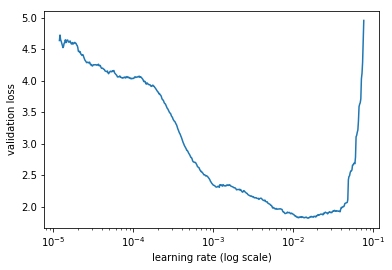

In [57]:
m.sched.plot()

In [59]:
m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0., 1, layers, [0.1, 0.2, 0.], yl_range, use_bn=False)

lr = 1e-3
m.fit(lr, 10, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.887539   0.651195   6.310502   166.664006
    1      0.705961   0.530223   7.840832   142.107334       
    2      0.605989   0.681308   6.06222    144.049715       
    3      0.528955   0.609463   8.789151   140.196643       
    4      0.486971   0.889219   7.874128   154.673644       
    5      0.43349    0.743367   8.479811   139.785426       
    6      0.417818   0.663641   7.424688   152.134878       
    7      0.326807   0.52379    10.289905  129.446114       
    8      0.286448   0.667345   9.020243   130.679224       
    9      0.307861   0.841659   11.323169  134.62876        



[array([0.84166]), 11.323168610587748, 134.62876001015658]

In [60]:
m.fit(lr, 2, metrics=[exp_rmspe, exp_mae], cycle_len=7)

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.275022   0.839572   10.398598  151.029763
    1      0.255794   0.773546   10.734896  137.21348        
    2      0.206234   0.637461   8.587306   121.256936       
    3      0.184001   0.701825   8.479757   130.753571       
    4      0.140869   0.648208   8.55898    127.823157       
    5      0.137766   0.71004    8.327877   128.322295       
    6      0.123285   0.702722   8.350022   126.923695       
    7      0.245953   1.346577   7.674965   161.865615       
    8      0.19199    0.94323    9.294486   139.979723       
    9      0.148756   0.8104     9.496974   138.906514       
    10     0.137206   0.792309   7.704528   127.41064        
    11     0.120128   0.828245   8.375836   129.168219       
    12     0.108388   0.839772   8.650364   131.870758        
    13     0.090113   0.825901   8.520691   129.587064        



[array([0.8259]), 8.520691075372595, 129.58706445157048]

In [61]:
m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0.4, 1, layers, [0.1, 0.2], yl_range, use_bn=False)

lr = 1e-3
m.fit(lr, 10, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae         
    0      1.354256   1.025551   8.806688   193.040341
    1      1.016022   1.232744   6.228882   204.237363       
    2      0.871377   0.781139   7.164645   170.978112       
    3      0.803529   0.788303   259.674396 397.132016       
    4      0.776728   0.723017   10.473801  154.99087        
    5      0.687421   0.614756   10.388431  140.13349        
    6      0.654558   0.47183    11.390322  140.911668       
    7      0.653678   0.59829    12.787337  157.990725       
    8      0.673935   0.778529   9.545429   154.47251        
    9      0.587017   0.507335   10.05752   129.38018        



[array([0.50734]), 10.057519830576258, 129.38018023375037]

In [63]:
m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0.4, 1, layers, [0.1, 0.2], yl_range, use_bn=False)

lr = 1e-2
m.fit(lr, 3, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae         
    0      26.252342  29.55109   0.97811    453.706804
    1      26.649398  29.55109   0.97811    453.706804      
    2      26.628359  29.55109   0.97811    453.706804      


[array([29.55109]), 0.9781096255335533, 453.7068040666713]

In [65]:
m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0., 1, layers, [0., 0.], yl_range, use_bn=False)

lr = 1e-3
m.fit(lr, 3, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.807262   1.307775   348.295613 540.868657
    1      0.694101   1.488499   7.470441   175.07525        
    2      0.62866    1.218445   9.263246   169.286151       


[array([1.21844]), 9.263246285533617, 169.2861508500306]

In [66]:
val_selection = ceds[ceds.entry_date > '2018-09-01']
val_idx = val_selection.index
val_idx


Int64Index([   988,    989,    990,    991,    992,    993,    994,    995,
               996,    997,
            ...
            106774, 106775, 106776, 106777, 106778, 106779, 106780, 106781,
            106782, 106783],
           dtype='int64', length=1490)

In [67]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=None)
m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0, 1, layers, [0., 0., 0.], yl_range, use_bn=False)
m.lr_find()

 66%|██████▌   | 548/831 [00:10<00:05, 54.64it/s, loss=5.8] 

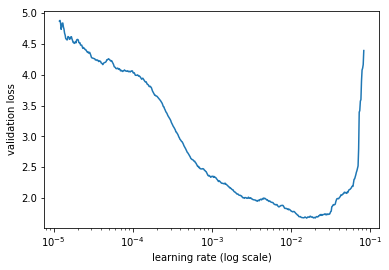

In [68]:
m.sched.plot()

In [69]:
m = md.get_learner(emb_szs, 
                   len(df.columns)-len(cat_vars),
                   0., 1, layers, [0., 0.], yl_range, use_bn=False)

lr = 1e-3
m.fit(lr, 5, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.812831   0.368957   1.661762   168.331403
    1      0.652342   0.19674    0.587055   108.880483       
    2      0.537487   0.155438   0.544755   100.087303       
    3      0.488682   0.179443   0.491901   103.129746       
    4      0.360269   0.162292   0.705926   94.396217        


[array([0.16229]), 0.7059259432400349, 94.39621681679016]

In [70]:
m.fit(lr, 5, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.360543   0.172317   0.385427   88.866261 
    1      0.327378   0.14518    0.425959   85.104174        
    2      0.268856   0.173752   0.583821   87.491492        
    3      0.268586   0.191608   0.857741   106.909527       
    4      0.201492   0.198593   0.535194   83.826285        


[array([0.19859]), 0.5351944872484252, 83.82628471235302]

In [71]:
m.fit(lr, 5, metrics=[exp_rmspe, exp_mae])

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.194595   0.169582   0.500405   83.599052 
    1      0.168699   0.160396   0.501243   82.817457        
    2      0.147782   0.178134   0.64718    80.682318        
    3      0.172753   0.171424   0.483464   100.871661       
    4      0.146864   0.170101   0.65868    97.779406        


[array([0.1701]), 0.6586802664274279, 97.77940649154202]

In [72]:
m.fit(lr, 3, metrics=[exp_rmspe, exp_mae], cycle_len=3)

epoch      trn_loss   val_loss   exp_rmspe  exp_mae          
    0      0.114321   0.175052   0.685727   78.238219 
    1      0.082389   0.165139   0.621815   79.011583         
    2      0.051973   0.169141   0.629437   82.746089         
    3      0.123959   0.184942   0.502371   110.875973        
    4      0.088271   0.166031   0.530959   81.31765          
    5      0.053788   0.170538   0.596763   81.855025         
    6      0.10832    0.180555   0.697444   97.289354         
    7      0.06309    0.159688   0.619647   77.064524         
    8      0.045665   0.162624   0.59676    78.577418         


[array([0.16262]), 0.5967595126901872, 78.5774177338453]

In [73]:
m.fit(lr, 3, metrics=[exp_rmspe, exp_mae], cycle_len=5)

epoch      trn_loss   val_loss   exp_rmspe  exp_mae           
    0      0.099532   0.18443    0.670121   88.206115 
    1      0.066169   0.152587   0.588683   81.799457         
    2      0.050382   0.158329   0.553828   80.570872         
    3      0.038433   0.158322   0.586648   77.701127         
    4      0.0324     0.161502   0.60612    79.352241         
    5      0.114401   0.190089   1.047363   81.814857         
    6      0.071662   0.162086   0.74686    79.704109         
    7      0.045159   0.180621   0.857741   80.083407         
    8      0.037464   0.179347   0.829497   77.975976         
    9      0.028495   0.18087    0.83734    79.651097         
    10     0.097896   0.228936   0.864029   109.394524        
    11     0.066105   0.180428   0.788094   88.545249         
    12     0.045762   0.16662    0.74778    77.994155         
    13     0.031292   0.175531   0.7959     79.561846         
    14     0.030281   0.173996   0.800306   79.726621         


[array([0.174]), 0.800305842172858, 79.72662089679065]

array([[563.3478 ],
       [579.15924],
       [571.9003 ],
       ...,
       [852.45935],
       [799.67285],
       [658.60864]], dtype=float32)

In [91]:
p = np.round(np.exp(m.predict()) - 1)
o = ceds.loc[val_idx, ['entry_date', 'facility', 'count']]
o['predict'] = p
o.head()

,entry_date,facility,count,predict
988,2018-09-14,0500165,501,562.0
989,2018-09-13,0500165,577,578.0
990,2018-09-12,0500165,466,571.0
991,2018-09-11,0500165,516,594.0
992,2018-09-10,0500165,501,483.0


In [134]:
facilities = ceds['facility'].unique().tolist()

import random
selection = random.sample (facilities, 5)
selection

['0503516', '0501577', '0503490', '0501239', '0502526']

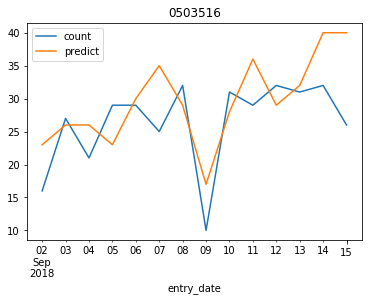

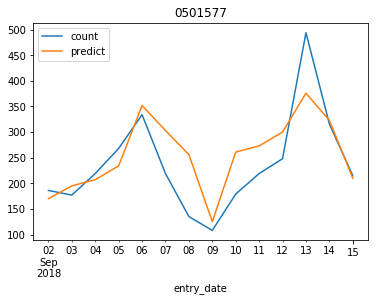

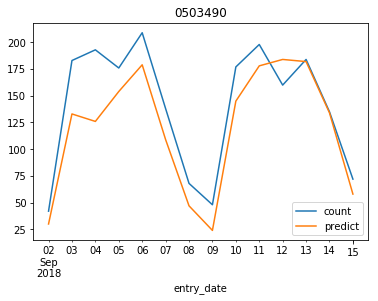

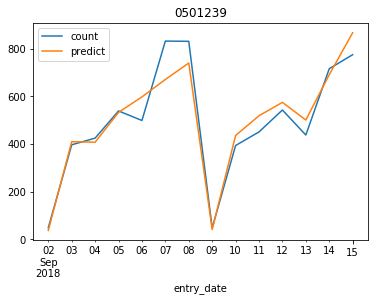

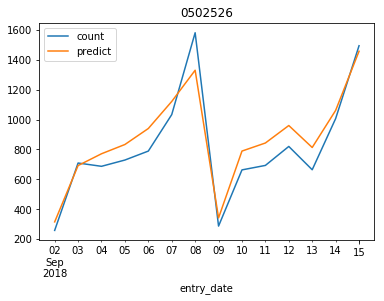

In [135]:
for f in selection:
    fo = o[o['facility'] == f]
    fo.plot(x = 'entry_date', y = ['count', 'predict'], title = f)